In [1]:
import torch
from torch import nn
import numpy as np

class Reshape(nn.Module): 
    def __init__(self, shape): 
        super(Reshape, self).__init__() 
        self.shape = shape 
    
    def forward(self, x): 
        return x.view(self.shape)

class ConvAutoEncoder(torch.nn.Module):
    
    def __init__(self, bottleneck_chans=8, bottleneck_dim=72, map_path=".\\data\\map.pt"):
        
        super(ConvAutoEncoder, self).__init__()
        # assert bottleneck_dim in {2, 8, 18, 32, 50, 72, 98, 128, 162, 200, 242, 288}  # must be twice a square number
        # sqrt = int(np.round((bottleneck_dim / 2) ** 0.5))
        self.bottleneck_chans = bottleneck_chans
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, dilation=3, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, dilation=2, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=64, out_channels=bottleneck_chans, kernel_size=4, dilation=3, stride=2, padding=0, padding_mode="circular"),
                                    nn.Tanh()
        )
        self.enLinear = nn.Linear(in_features=35 * 74 * bottleneck_chans, out_features=bottleneck_dim)  # this must be changed if the above is modified
        
        
        self.decoder1 = nn.Sequential(nn.Linear(in_features=bottleneck_dim, out_features=35 * 74 * bottleneck_chans),
                                    Reshape((-1, bottleneck_chans, 35, 74)),
                                    nn.ConvTranspose2d(in_channels=bottleneck_chans, out_channels=64, kernel_size=4, dilation=3, stride=5, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=8, stride=5, padding=2),
                                    nn.Tanh())
        self.map = torch.load(map_path)
        self.outputConv1 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, dilation=2, padding=4, padding_mode="circular")
        self.outputConv2 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=5, dilation=2, padding=4, padding_mode="circular")

    def forward(self, data):
        x = self.encoder(data)
        print(x.detach().shape)
        x = nn.Tanh()(self.enLinear(nn.Flatten(start_dim=1, end_dim=-1)(x)))
        x = self.decoder1(x)
        print(x.detach().shape)

        x = x[:, :, 5:726, 10:1450] + self.map
        x = nn.Tanh()(self.outputConv1(x))
        x = self.outputConv2(x)
        return x




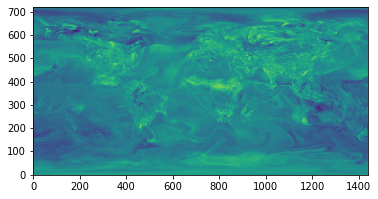

In [20]:
import xarray as xr
import matplotlib.pyplot as plt

def get_data_nc4(path):
    """ returns data of shape (t, 1, w, h) representing a series of log-images"""
    data = xr.open_dataset(path)
    darr = data.to_array()[0, :, 0, :, :].to_numpy() # remove elev and species dimensions
    
    darr = torch.tensor(darr)[:, None, :, :]  # shape (t, 1 chan, w, h)
    # darr = torch.transpose(torch.transpose(darr, dim0=0, dim1=2), dim0=0, dim1=1)[None, :, :, :]  # shape (t, 1, w, h)
    
    return torch.log(darr + 1e-30)

def get_data(path):
    """ returns data of shape (t, 1, w, h) representing a series of log-images"""
    darr = np.load(path)
    darr = torch.tensor(darr)
    
    return darr

from torch.optim import Adam

data = get_data(r"./data/NO2_" + "2018-01-31" + ".npy") # 3d tensor of snapshots
mean_over_time = torch.load(f"data/map_mean_over_time.pt")
data -= mean_over_time
plt.imshow(data[0, 0, :, :], origin="lower")

tensor(-20.9606)

In [46]:
# reproducibility
seed = 633

print("[ Using Seed : ", seed, " ]")

import torch
import random
import numpy as np
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

batch_size = 8
lr = 1e-7
wd = 1e-5

model = ConvAutoEncoder(bottleneck_chans=1, bottleneck_dim=2000, map_path=".\\data\\map_normalized.pt")
opt = Adam(model.parameters(), lr=lr, weight_decay=wd)
epochs = 0

[ Using Seed :  633  ]


In [47]:
[p.size() for p in model.parameters()]

[torch.Size([16, 1, 4, 4]),
 torch.Size([16]),
 torch.Size([64, 16, 4, 4]),
 torch.Size([64]),
 torch.Size([1, 64, 4, 4]),
 torch.Size([1]),
 torch.Size([2000, 2590]),
 torch.Size([2000]),
 torch.Size([2590, 2000]),
 torch.Size([2590]),
 torch.Size([1, 64, 4, 4]),
 torch.Size([64]),
 torch.Size([64, 16, 8, 8]),
 torch.Size([16]),
 torch.Size([1, 16, 5, 5]),
 torch.Size([1]),
 torch.Size([1, 8, 5, 5]),
 torch.Size([1])]

In [48]:
for i in range(1):
    for batch in range(data.shape[0] // batch_size):
        opt.zero_grad()
        batch_data = data[batch_size * batch:batch_size * (batch + 1)]
        reconstruction = model(batch_data)
        error = torch.mean((reconstruction - batch_data) ** 2)
        error.backward()
        print(error.detach())
        opt.step()
    epochs += 1

torch.Size([8, 1, 35, 74])
torch.Size([8, 16, 879, 1854])


RuntimeError: Given groups=1, weight of size [1, 8, 5, 5], expected input[8, 1, 729, 1448] to have 8 channels, but got 1 channels instead

In [53]:
data.std()

tensor(0.9183)

In [ ]:
plt.imshow(reconstruction.detach()[0, 0], origin="lower")

In [12]:
torch.mean((reconstruction.detach()[:, :, :, :]) ** 2)

tensor(0.0035)

In [15]:
reconstruction.detach().mean()

tensor(-0.0202)

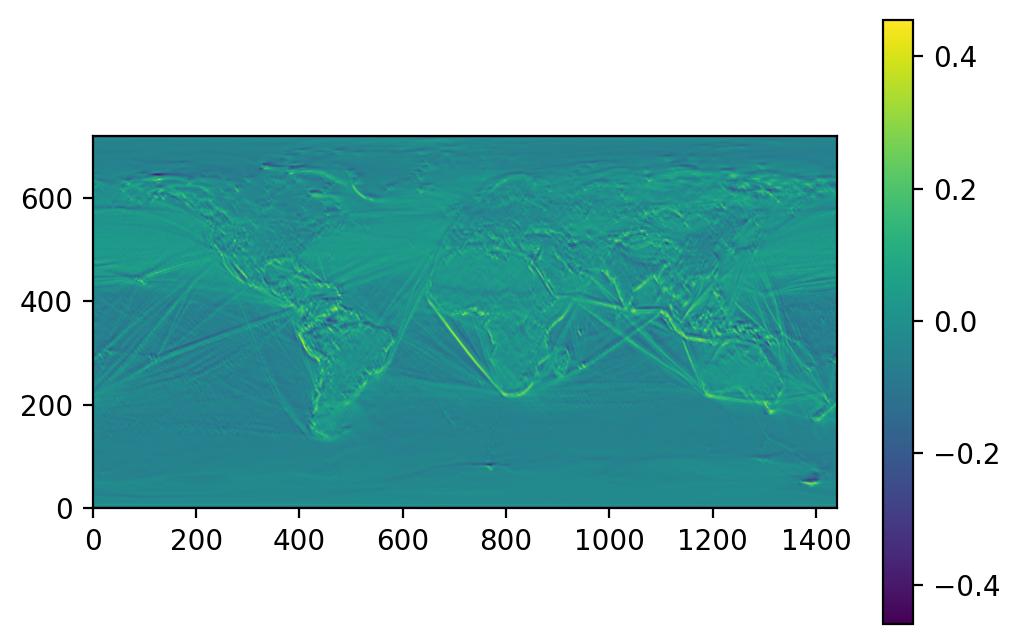

In [18]:
plt.figure(dpi=200)
plt.imshow(reconstruction.detach().numpy()[0, 0, :, :], origin="lower")
plt.colorbar()

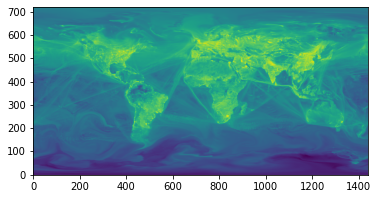

In [27]:
plt.imshow(data[0, 0], origin="lower")

In [ ]:
import torch
from torch import nn
from dpk import model_objs


class ConvAutoEncoder(torch.nn.Module):
    
    def __init__(self, bottleneck_chans=8):
        
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=2, kernel_size=4, stride=4, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=2, out_channels=3, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh(),
                                    nn.Conv2d(in_channels=4, out_channels=bottleneck_chans, kernel_size=4, stride=3, padding=0, padding_mode="circular"),
                                    nn.Tanh()
        )
                                    
        self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=bottleneck_chans, out_channels=8, kernel_size=4, stride=3, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh(),
                                    nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=4, stride=4, padding=2),
                                    nn.Tanh()
        )

    def forward(self, data):
        encoding = self.encoder(data)
        return self.decoder(encoding)

import xarray as xr

def get_data(path):
    data = xr.open_dataset(path)
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    darr = torch.tensor(darr)[:, None, :, :]  # shape (t, 1 chan, w, h)
    # darr = torch.transpose(torch.transpose(darr, dim0=0, dim1=2), dim0=0, dim1=1)[None, :, :, :]  # shape (1, w, h, t)
    
    return torch.log(darr + 1e-30)

    
from torch.optim import Adam

data = get_data(r"./data/NO2_" + "2018-01-31" + ".nc4") # 3d tensor of snapshots
plt.imshow(data[0, 0, :, :], origin="lower")
# reproducibility
seed = 633

print("[ Using Seed : ", seed, " ]")

import torch
import random
import numpy as np
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

batch_size = 8
lr = 1e-5
wd = 1e-5

model = ConvAutoEncoder(bottleneck_chans=16)
opt = Adam(model.parameters(), lr=lr, weight_decay=wd)
epochs = 0
for i in range(500):
    for batch in range(data.shape[0] // batch_size):
        opt.zero_grad()
        batch_data = data[batch_size * batch:batch_size * (batch + 1)]
        reconstruction = model(batch_data)[:, :, 50:771, 100:1540]
        error = torch.sum((reconstruction - batch_data) ** 2)
        error.backward()
        opt.step()
    epochs += 1
model(batch_data).shape, batch_data.shape, model.encoder(batch_data)

# data = data.cuda()
# model = model.cuda()
# model = ConvAutoEncoder(bottleneck_chans=16)
# param_str = f"ConvAutoEncoder_{batch_size}_{epochs}_{seed}_{wd}_{lrt}"
# model.load_state_dict(torch.load(f"./forecasts/model_{param_str}.pt"))
# torch.save(model.state_dict(), f"./forecasts/model_{param_str}.pt")

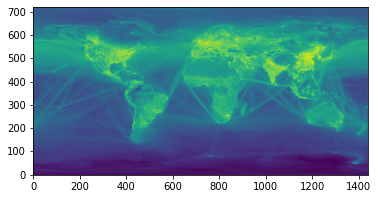

In [9]:
import os

# create map -- the average of 240 random snapshots
# ["2018-01-31", "2018-3-16", "2018-07-21", "2018-10-20", "2018-11-25",...
wmap = None
files = os.listdir(r"./data/")
for fname in files:
    if fname.startswith("map"):
        continue
    data = get_data(os.path.join(r"./data/", fname)) # 3d tensor of snapshots
    if wmap is None:
        wmap = torch.mean(data, dim=0)
    else:
        wmap += torch.mean(data, dim=0)
wmap /= len(files)
torch.save(wmap, "./data/map_mean_over_time.pt")
wmap -= wmap.mean()
wmap /= wmap.std()
plt.imshow(wmap[0], origin="lower")

In [10]:
torch.save(wmap, "./data/map_normalized.pt")

In [53]:
# convert to .npy files because lambda machine doesn't have hd5
source_path = "D:/atmo-chem/data"
dest_path = "D:/atmo-chem/data/numpy/test"
files = os.listdir(source_path)[365 * 2:]
files = np.random.choice(files, size=3, replace=False)
for fname in files:
    print(fname)
    if fname.startswith("map") or fname.endswith(".npy"):
        continue
    data = get_data_nc4(os.path.join(source_path, fname)) # 3d tensor of snapshots
    np.save(os.path.join(dest_path, fname[:-4] + ".npy"), data.numpy())

NO2_2020-01-23.nc4
NO2_2020-02-02.nc4
NO2_2020-03-05.nc4


In [37]:
data.numpy().dtype

dtype('float32')

In [59]:
K = 200
name = "2018-19_gaussianOmega"
U = np.load(f"D:/atmo-chem/{name}_rank{K}U.npy")
s = np.load(f"ristretto/{name}_rank{K}sigmas.npy")

In [63]:
U = torch.tensor(U)[None, :, :]
U.shape

torch.Size([1, 1038240, 200])

In [77]:
s = torch.sqrt(torch.sum(U**2, dim=1))

In [78]:
s

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0

In [62]:
k = 20
np.save(f"D:/atmo-chem/UxS_{name}_rank{k}.npy", (U * s)[:, :k])

In [33]:
flattened = nn.Flatten(start_dim=2)(data)
(flattened @ U).shape

torch.Size([24, 1, 200])

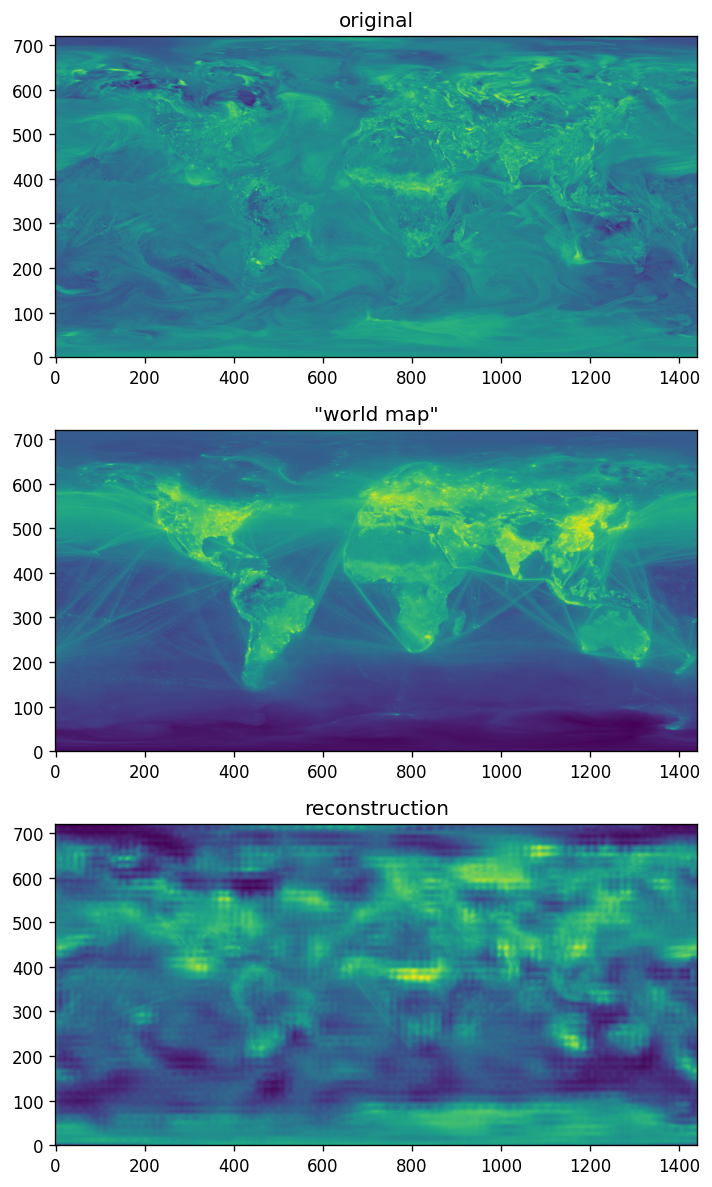

In [82]:
r = torch.load("reconstruction_ConvAutoEncoder_1642657949.28883_8_500_633_0.0001_0.0001.pt", map_location=torch.device('cpu')).detach()
plt.figure(figsize=(10, 10), dpi=120)
plt.subplot(311)
plt.title("original")
plt.imshow(data[-1, 0], origin="lower")
plt.subplot(312)
plt.title("\"world map\"")
plt.imshow(wmap[0], origin="lower")
plt.subplot(313)
plt.title("reconstruction")
plt.imshow(r[-1, 0], origin="lower")
# plt.colorbar()
plt.tight_layout()

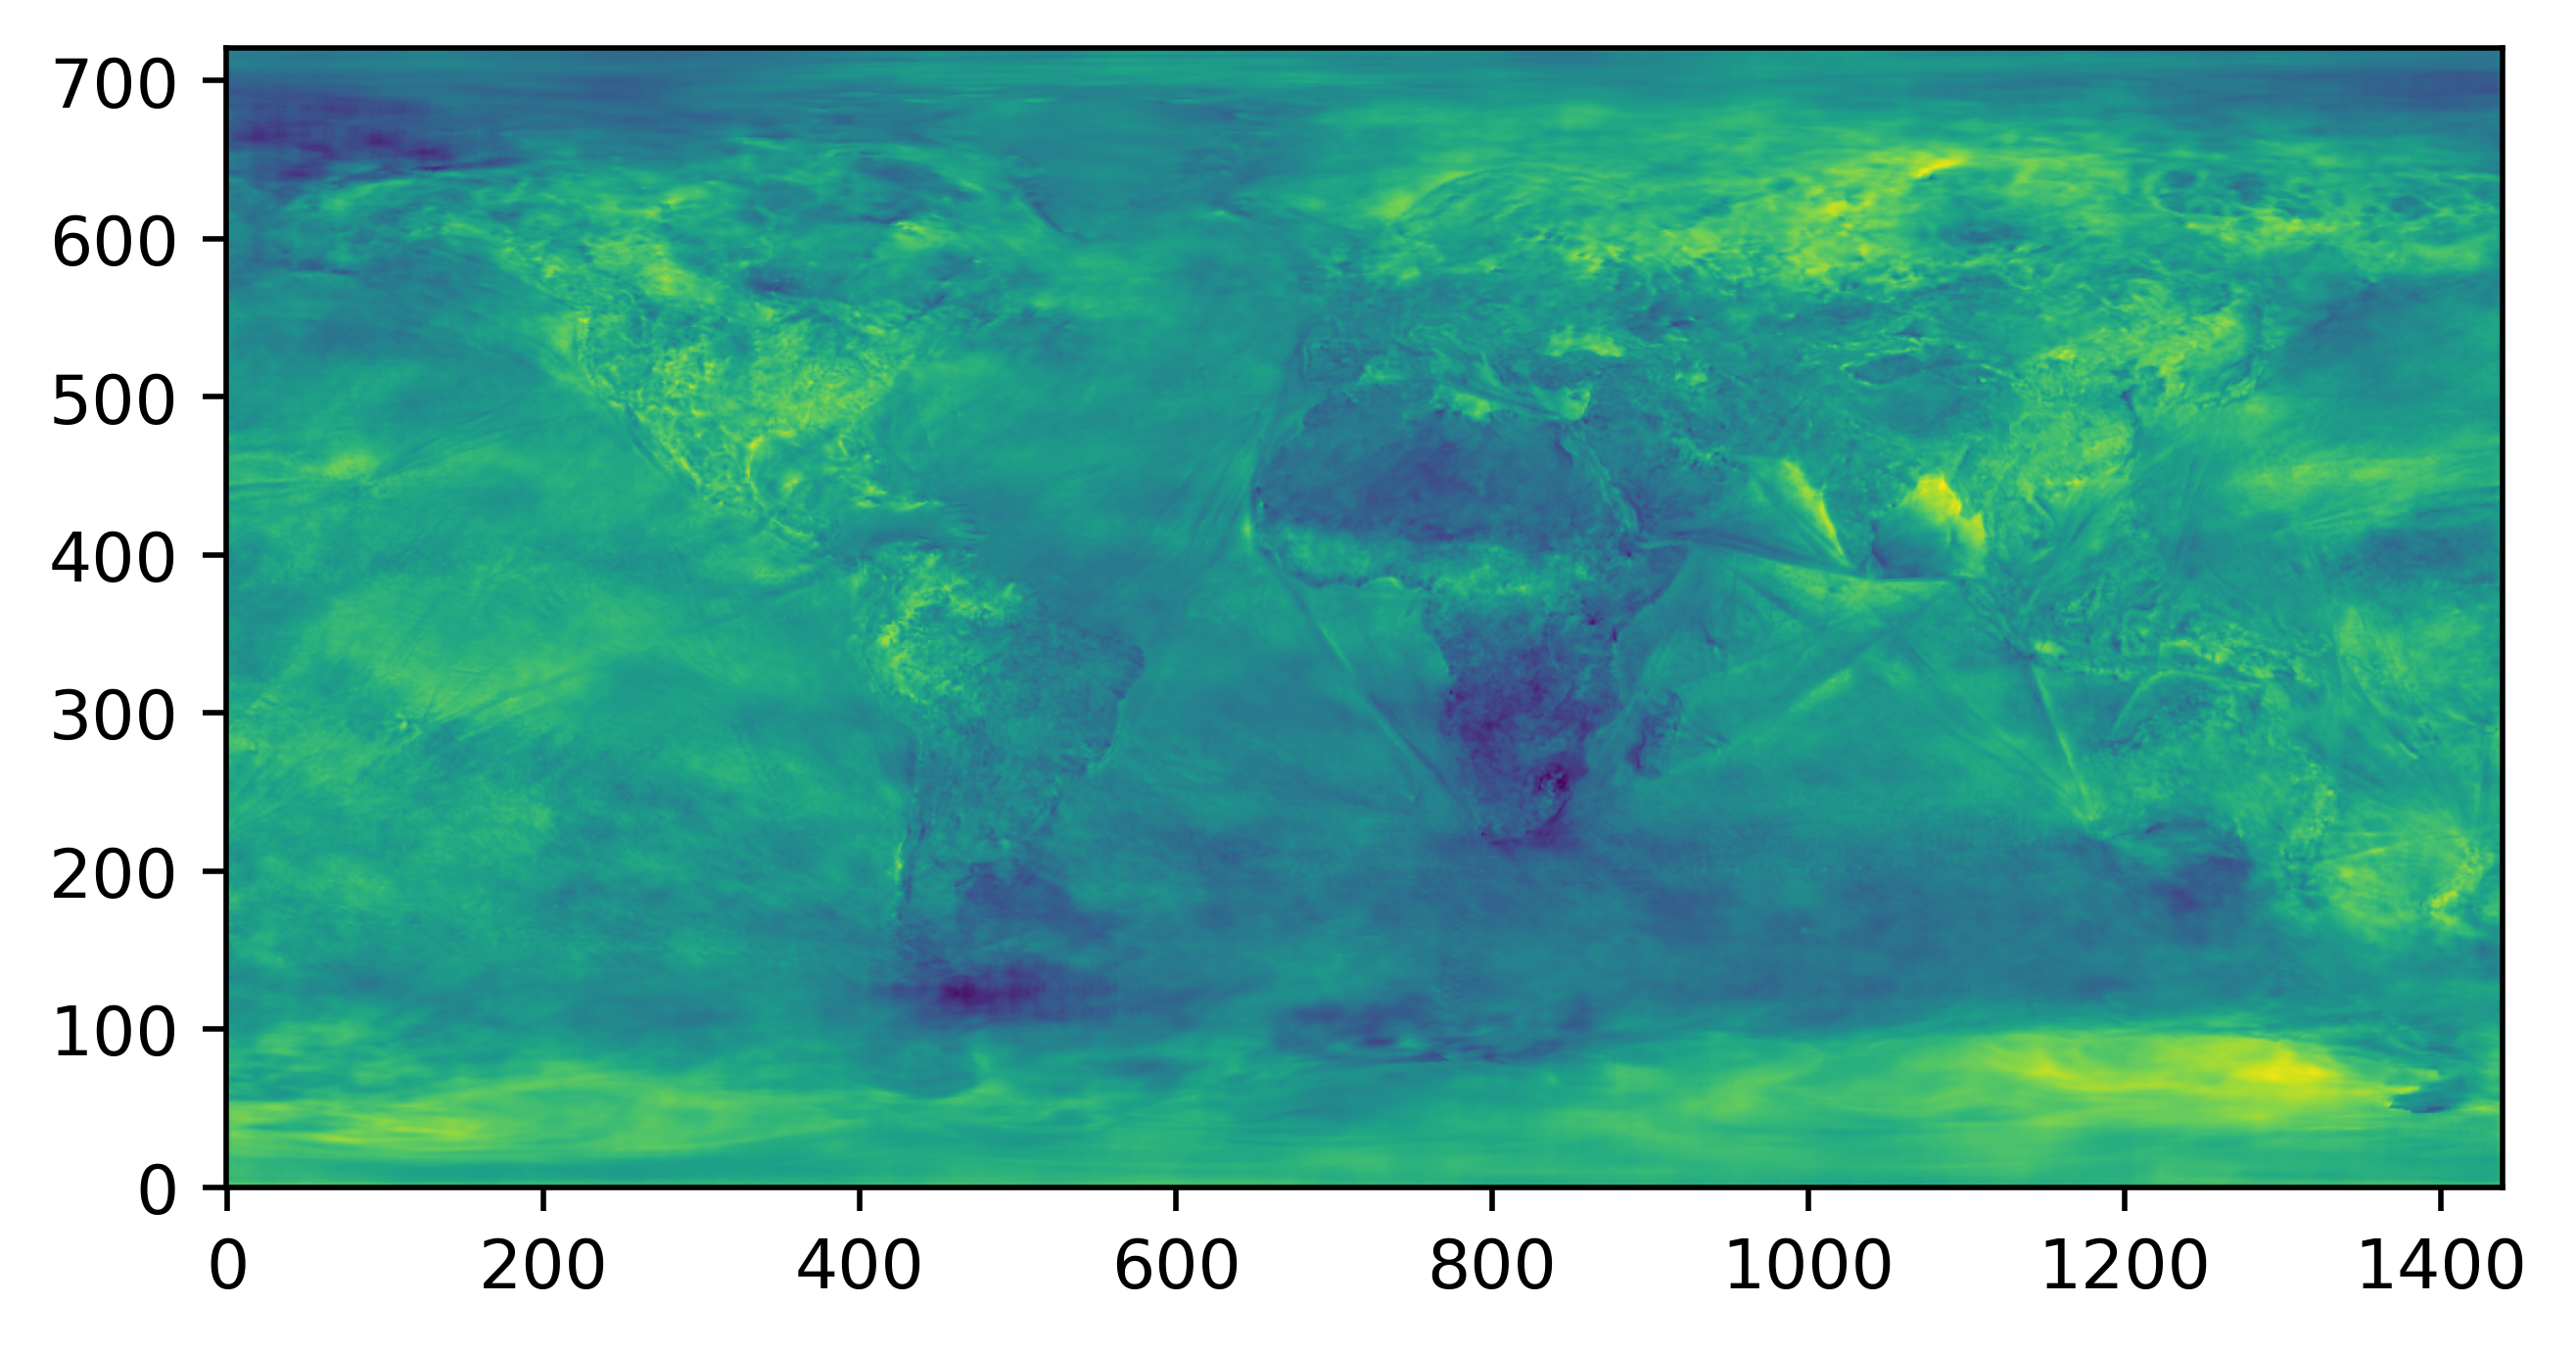

In [5]:
import torch
import matplotlib.pyplot as plt
r = torch.load("reconstruction_ConvAutoEncoder_1643254695.0237641_6_10_633_0_0.0003.pt", map_location=torch.device('cpu')).detach()
plt.figure(dpi=500)
plt.imshow(r[0, 0], origin="lower")

In [ ]:
r.

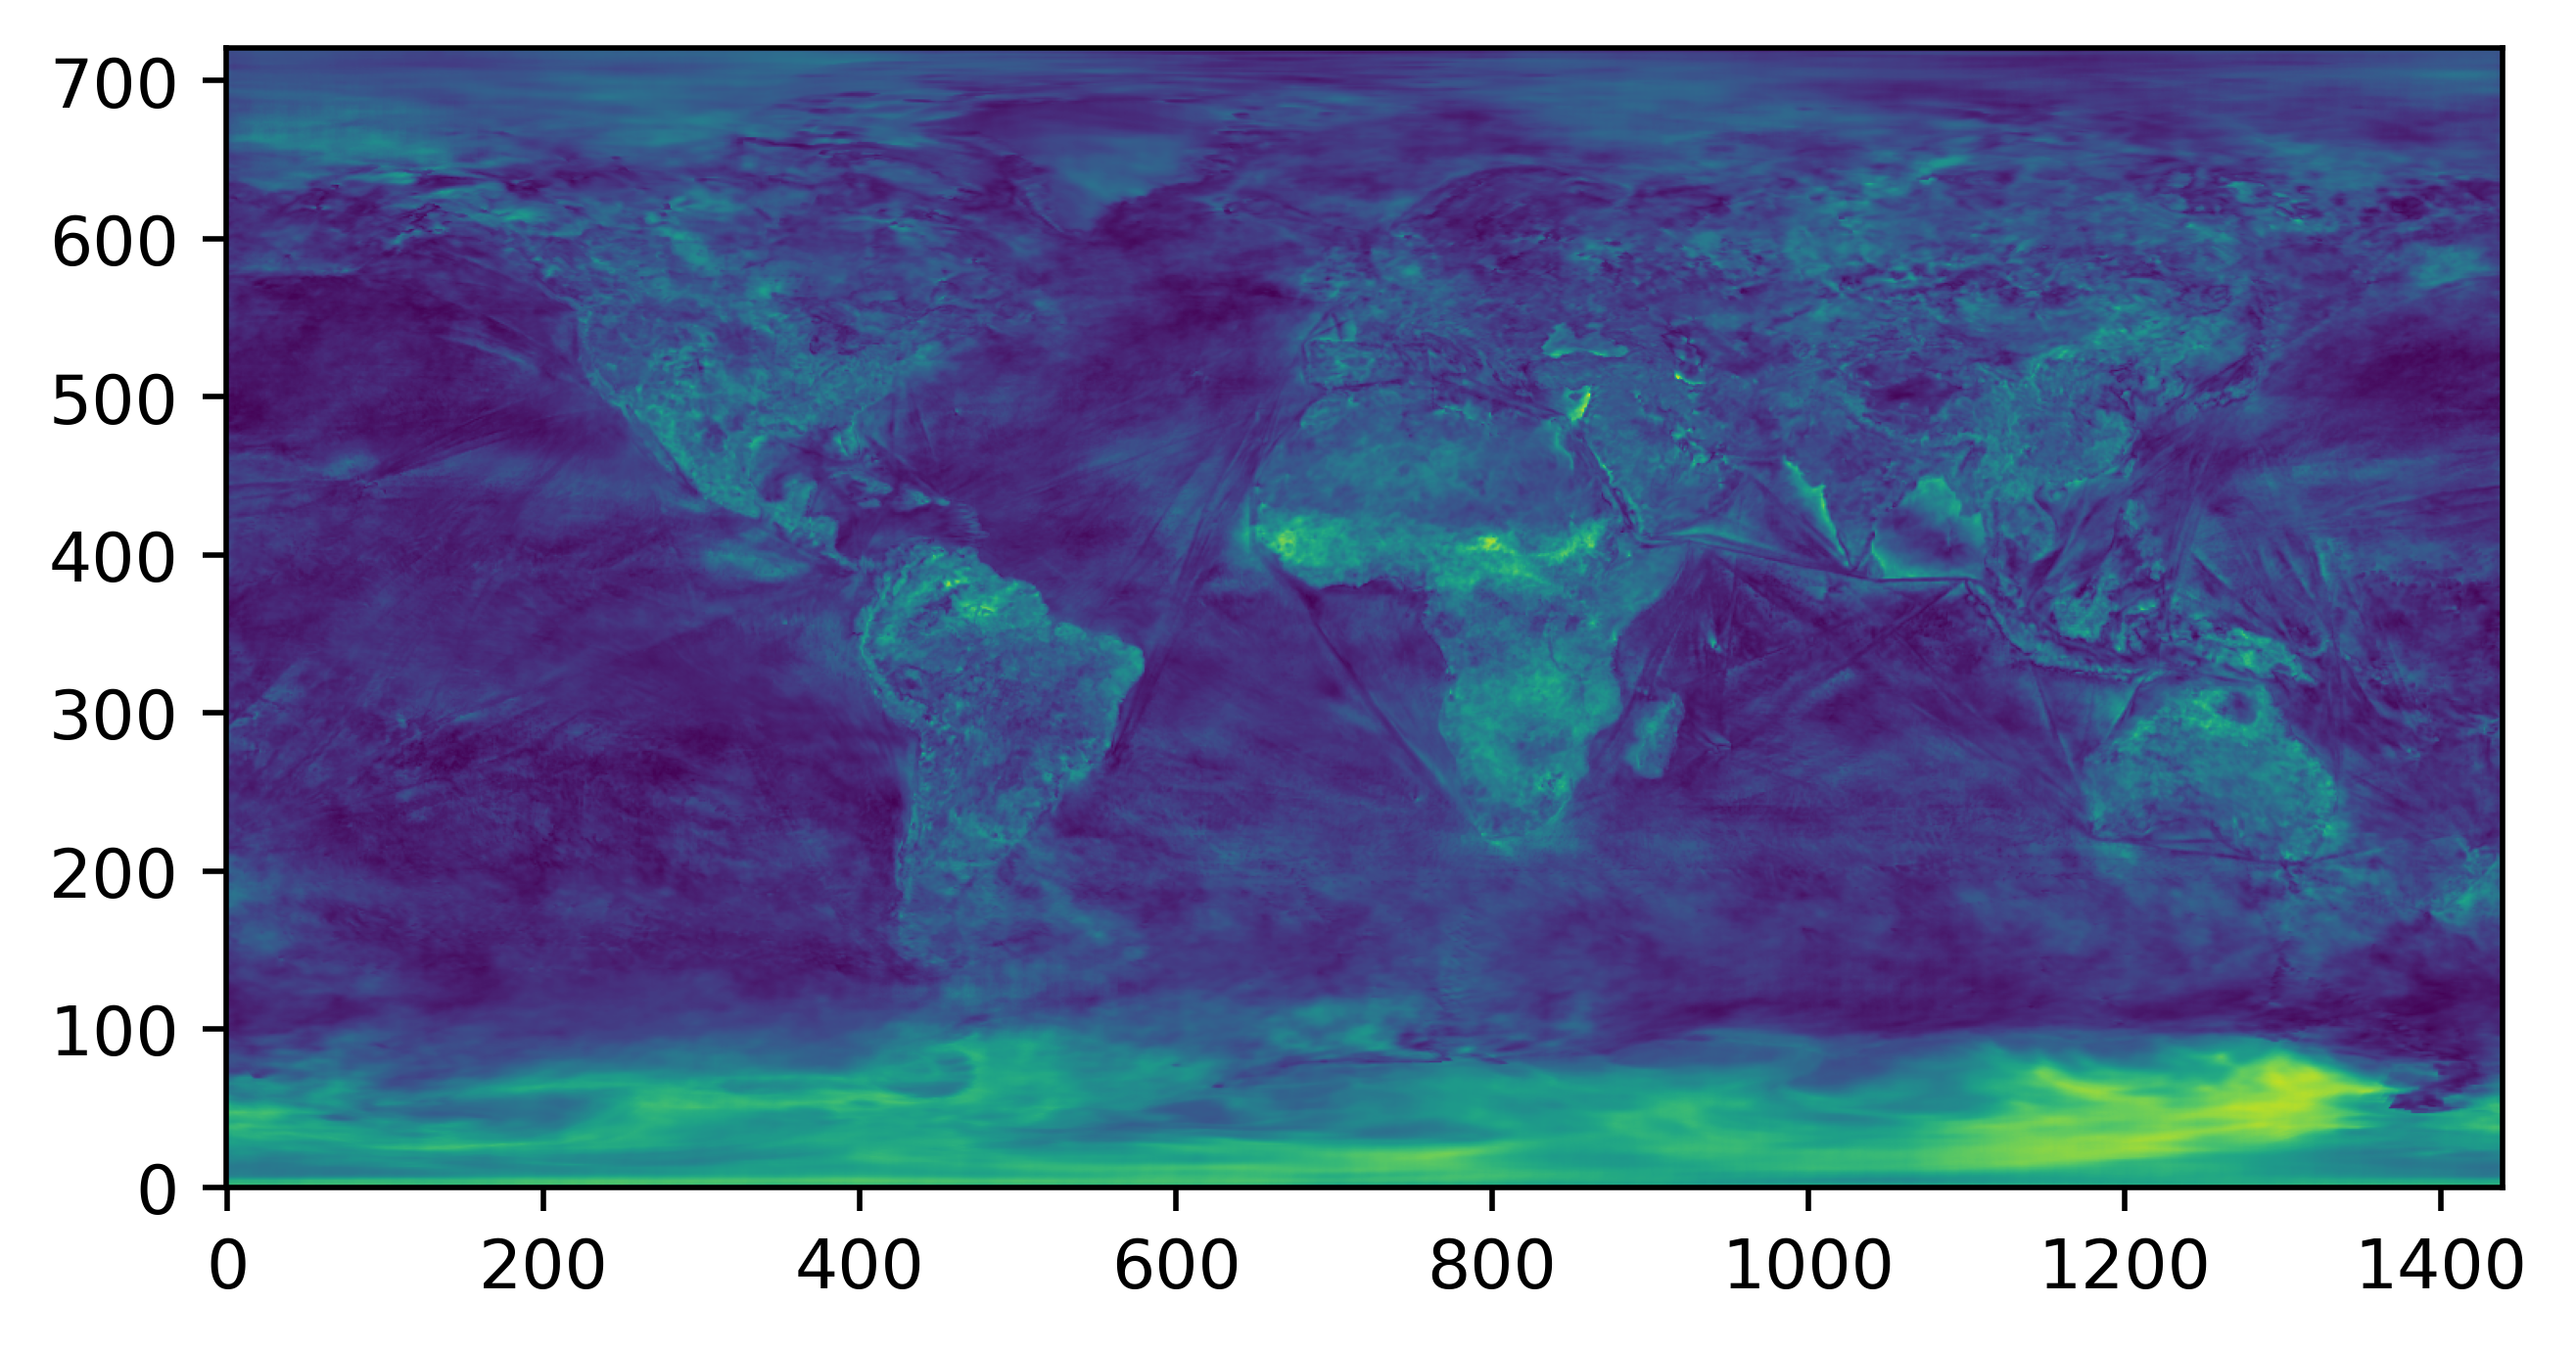

In [8]:
plt.figure(dpi=500)
plt.imshow(r.std(dim=0)[0], origin="lower")

In [21]:
data.std(dim=0).mean()

tensor(0.4173)

In [81]:
torch.mean((r.std(dim=0)==0).type(torch.float64))

tensor(0.9813, dtype=torch.float64)

In [101]:
# convert to .npy files because henning's machine doesn't have hd5
dirname = r"D:/atmo-chem/data/"
files = os.listdir(dirname)
for fname in np.random.choice(files[:365 * 2], 10, replace=False):
    print(fname)
    data = get_data_nc4(os.path.join(dirname, fname)) # 3d tensor of snapshots
    np.save(os.path.join(dirname, fname[:-4] + ".npy"), data.numpy())

NO2_2019-02-23.nc4
NO2_2018-09-03.nc4
NO2_2019-02-16.nc4
NO2_2018-11-17.nc4
NO2_2019-04-13.nc4
NO2_2019-10-17.nc4
NO2_2018-01-10.nc4
NO2_2019-07-05.nc4
NO2_2018-04-18.nc4
NO2_2019-04-28.nc4


In [49]:
data.shape

torch.Size([24, 1, 721, 1440])

In [50]:
words = """NO2_2019-10-11.npy                            100%   95MB 699.6KB/s   02:19
NO2_2018-09-03.npy                            100%   95MB 700.1KB/s   02:19
NO2_2019-04-17.npy                            100%   95MB 700.0KB/s   02:19
NO2_2019-09-14.npy                            100%   95MB 700.1KB/s   02:19
NO2_2018-02-25.npy                            100%   95MB 700.2KB/s   02:19
NO2_2018-09-05.npy                            100%   95MB 699.8KB/s   02:19
NO2_2019-09-17.npy                            100%   95MB 699.8KB/s   02:19
NO2_2019-07-05.npy                            100%   95MB 699.5KB/s   02:19
NO2_2019-08-11.npy                            100%   95MB 699.3KB/s   02:19
NO2_2019-12-05.npy                            100%   95MB 666.2KB/s   02:26
NO2_2018-06-15.npy                            100%   95MB 700.1KB/s   02:19
NO2_2018-11-02.npy                            100%   95MB 699.8KB/s   02:19
NO2_2018-04-05.npy                            100%   95MB 699.5KB/s   02:19
NO2_2018-04-21.npy                            100%   95MB 699.9KB/s   02:19
NO2_2019-10-13.npy                            100%   95MB 699.4KB/s   02:19
NO2_2018-03-06.npy                            100%   95MB 697.7KB/s   02:19
NO2_2018-11-16.npy                            100%   95MB 699.8KB/s   02:19
""".split()

In [51]:
dates = words[::5]

In [52]:
print(" ".join(dates))

NO2_2019-10-11.npy NO2_2018-09-03.npy NO2_2019-04-17.npy NO2_2019-09-14.npy NO2_2018-02-25.npy NO2_2018-09-05.npy NO2_2019-09-17.npy NO2_2019-07-05.npy NO2_2019-08-11.npy NO2_2019-12-05.npy NO2_2018-06-15.npy NO2_2018-11-02.npy NO2_2018-04-05.npy NO2_2018-04-21.npy NO2_2019-10-13.npy NO2_2018-03-06.npy NO2_2018-11-16.npy
